In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import h5py
import sys

sys.path.append('../')

from cnn.commons import show_images, ft_train_model, visualize_model, save_dict_to_hdf5

plt.ion()   # interactive mode

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [41]:
torch.manual_seed(78)
np.random.seed(78)

#data_dir = '../data/chest_xray'
data_dir = '../data/rsna-bone-age'

n_labels = 12

In [57]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        #bone
        transforms.Normalize([0.18805075, 0.18805075, 0.18805075], [0.1892409, 0.1892409, 0.1892409])
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        #bone
        transforms.Normalize([0.18805075, 0.18805075, 0.18805075], [0.1892409, 0.1892409, 0.1892409])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]) for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                        shuffle=True, num_workers=4) for x in ['train', 'test']}

In [45]:
pop_mean = []
pop_std = []

for data in dataloaders['train']:
    numpy_image = data[0].data.numpy()
    
    batch_mean = np.mean(numpy_image, axis=(0,2,3))
    batch_std = np.std(numpy_image, axis=(0,2,3))
    
    pop_mean.append(batch_mean)
    pop_std.append(batch_std)

pop_mean = np.array(pop_mean).mean(axis=0)
pop_std = np.array(pop_std).mean(axis=0)

In [53]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

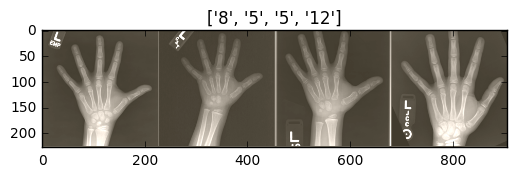

In [54]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

show_images(out, title=[class_names[x] for x in classes])

### VGG16

In [72]:
model_ft = models.vgg16(pretrained=True)
model_ft = model_ft.eval()
for param in model_ft.features.parameters():
    param.requires_grad = False

num_ftrs = model_ft.classifier[-1].in_features
temp = list(model_ft.classifier.children())[:-1]
temp.append(nn.Linear(num_ftrs, n_labels))
model_ft.classifier = nn.Sequential(*temp)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.classifier.parameters(), lr=1e-3, weight_decay=1e-3)

### ResNet18

In [20]:
model_ft = models.resnet18(pretrained=True)
model_ft = model_ft.eval()
for param in model_ft.parameters():
    param.requires_grad = False
    
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, n_labels)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.fc.parameters(), lr=1e-3, weight_decay=1e-3)

In [76]:
model_ft = ft_train_model(model_ft, criterion, optimizer_ft, dataloaders, device,
                          dataset_sizes, class_names, num_epochs=50)

Epoch 0/49
----------
train Loss: 1.8244 Acc: 0.3305
test Loss: 1.6965 Acc: 0.3155

Epoch 1/49
----------
train Loss: 1.6988 Acc: 0.3393
test Loss: 1.7054 Acc: 0.3127

Epoch 2/49
----------
train Loss: 1.6739 Acc: 0.3485
test Loss: 1.7017 Acc: 0.3187

Epoch 3/49
----------
train Loss: 1.7040 Acc: 0.3409
test Loss: 1.6772 Acc: 0.3310

Epoch 4/49
----------
train Loss: 1.7105 Acc: 0.3435
test Loss: 1.6755 Acc: 0.3076

Epoch 5/49
----------
train Loss: 1.7311 Acc: 0.3328
test Loss: 1.6605 Acc: 0.3365

Epoch 6/49
----------
train Loss: 1.7116 Acc: 0.3380
test Loss: 1.7109 Acc: 0.3076

Epoch 7/49
----------
train Loss: 1.7148 Acc: 0.3422
test Loss: 1.6476 Acc: 0.3282

Epoch 8/49
----------
train Loss: 1.7169 Acc: 0.3435
test Loss: 1.7001 Acc: 0.2941

Epoch 9/49
----------
train Loss: 1.7052 Acc: 0.3411
test Loss: 1.6981 Acc: 0.3218

Epoch 10/49
----------
train Loss: 1.7078 Acc: 0.3439
test Loss: 1.7019 Acc: 0.3214

Epoch 11/49
----------
train Loss: 1.7010 Acc: 0.3520
test Loss: 1.6846 Acc

In [ ]:
visualize_model(model_ft, dataloaders, class_names, device, num_images=2)

In [ ]:
weight_dict = {'fl_W:0' : model_ft.state_dict()['classifier.6.weight'].cpu().data.numpy(),
               'fl_b:0' : model_ft.state_dict()['classifier.6.bias'].cpu().data.numpy()}

#save_dict_to_hdf5(weight_dict, 'finetune_model.ptch')